In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

def getName(ticker):
    # Scrapes full security name from Yahoo Finance Profile site.
    # Takes ticker str as input
    # Returns str as output
    import requests
    from bs4 import BeautifulSoup as bs4
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    des_page_source = requests.get("https://finance.yahoo.com/quote/"+ticker+"/profile?p="+ticker, headers=headers) #requests website
    des_soup = bs4(des_page_source.text, 'html.parser') #parses HTML into plaintext
    return des_soup.find_all('h1')[1].text

def getData(tickerbenchlist, start_date, end_date):
    # Retrieves OHLC, Volume, Adjusted Close from Yahoo Finance API for specified ticker and benchmark
    # Takes as inputs [ticker, benchmark], datetime.datetime for start and end dates
    # Returns pandas dataframe
    import yfinance as yf
    data = yf.download(tickerbenchlist, start=start_date, end=end_date)
    return data

def scrapePrice(ticker):
    # Uses requests and BS4 to scrape the current price of the str ticker input from Yahoo Finance
    # Returns float of current ticker price
    import requests
    from bs4 import BeautifulSoup as bs4
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    url = "https://finance.yahoo.com/quote/"+ticker+"/history?p="+ticker
    site = requests.get(url, headers=headers).text
    soup = bs4(site)
#     return float((soup.select('table td')[4].text).replace(',',''))
    return ticker

def computeReturns(raw_data, ticker, benchmark, logrets=False, adjClose=False):
    # compute percent returns from input raw_data pandas dataframe (from getData function)
    # can compute log or pct_change (default=pct_change) from Close or Adj Close (default=Close)
    # returns (pandas.Series[0] = ticker_returns, pandas.Series[1] = bench_returns
    if adjClose:
        ticker_close = raw_data['Adj Close'][ticker]
        bench_close= raw_data['Adj Close'][benchmark]
    else:
        ticker_close = raw_data['Close'][ticker]
        bench_close= raw_data['Close'][benchmark]
    if logrets:
        ticker_rets = (ticker_close / ticker_close.shift(1)).apply(np.log).fillna(0)
        bench_rets = (bench_close / bench_close.shift(1)).apply(np.log).fillna(0)
    else:
        ticker_rets = ticker_close.pct_change().fillna(0)
        bench_rets = bench_close.pct_change().fillna(0)
    return ticker_rets, bench_rets

def describeRets(ticker_rets, bench_rets, VaRConf=.99):
    # Computes risk measures of a security's DAILY RETURNS against the DAILY RETURNS of a benchmark. 
    # Takes pandas.Series as inputs for ticker and benchmark DAILY returns.
    # Returns python dict data type
    import scipy
    beta, alpha, corr, p, std_err = scipy.stats.linregress(bench_rets, ticker_rets)
    return {'daily mean': np.mean(ticker_rets),
           'annualized mean': np.mean(ticker_rets)*252,
           'daily stdDev': np.std(ticker_rets),
           'annualized stdDev': np.std(ticker_rets)*252**.5,
           'kurtosis': scipy.stats.kurtosis(ticker_rets),
           'skew': scipy.stats.skew(ticker_rets),
           'sharpe ratio': (np.mean(ticker_rets) * 252) / (np.std(ticker_rets)*252**.5),
           'sortino': (np.mean(ticker_rets) * 252) / (np.std(ticker_rets[ticker_rets < 0]) * 252 ** .5),
           'treynor': np.mean(ticker_rets)/beta,
#            'Historical VaR ('+str(VaRConf*100)+'% confidence)': scrapePrice(ticker_rets.name) * ticker_rets.dropna().quantile(1-VaRConf),
#            'Parametric VaR ('+str(VaRConf*100)+'% confidence)': scrapePrice(ticker_rets.name) * scipy.stats.norm.ppf(1-VaRConf)*np.std(ticker_rets),
           'beta': beta,
           'alpha': alpha, 
           'correlation': corr,
           'std error': std_err}

def printStats(describeRets):
    # Helper function for printing describeRets function
    # Takes describeRets dict as input
    # Returns str data type
    printed_stats = ''
    for key, value in describeRets.items():
        if 'daily mean' == key:
            printed_stats+=key+ ': ' + str(round(value*100,4))+'%\n'
        elif 'annualized mean' == key:
            printed_stats+=key+ ': ' + str(round(value*100,4))+'%\n'
        elif 'daily stdDev' == key:
            printed_stats+=key+ ': ' + str(round(value*100,4))+'%\n'
        elif 'annualized stdDev' == key:
            printed_stats+=key+ ': ' + str(round(value*100,4))+'%\n'
        elif 'Historical VaR' in key:
            printed_stats+=key+ ': $' + str(round(value,2))+'\n'
        elif 'Parametric VaR' in key:
            printed_stats+=key+ ': $' + str(round(value,2))+'\n'
        else:
            printed_stats+=key+ ': ' + str(round(value,4))+'\n'
    return printed_stats



def graphHistDescribe(ticker_rets, bench_rets):
    # Graphs frequency histogram of daily returns
    # Takes pandas.Series as inputs
    # Retuns ax
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    ticker, benchmark, startdate, enddate = ticker_rets.name, bench_rets.name, str(ticker_rets.index[0])[:10], str(ticker_rets.index[-1])[:10]
    ticker_stats = describeRets(ticker_rets, bench_rets)
    bench_stats = describeRets(bench_rets, bench_rets)
    fig, ax  = plt.subplots(figsize=(20,10))
    ax.hist(ticker_rets,bins=250, density=True, histtype='stepfilled', alpha=0.5, label=ticker, color='r')
    ax.hist(bench_rets,bins=250, density=True, histtype='stepfilled', alpha=0.5, label=benchmark, color='b')
    ax.set_xlabel('Returns')
    ax.set_ylabel('Frequency')
    ax.set_title('Frequency distribution of '+ticker+' daily returns vs '+ benchmark + ' daily returns\n'+str(startdate)+' - '+str(enddate))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.text(0.05,0.95,ticker_rets.name+'\n'+printStats(ticker_stats),transform=ax.transAxes, verticalalignment='top')
    ax.text(0.05,0.55,bench_rets.name+'\n'+printStats(bench_stats),transform=ax.transAxes, verticalalignment='top')
    x1 = np.linspace(ticker_stats['daily mean']-6 * ticker_stats['daily stdDev'], ticker_stats['daily mean'] + 6 * ticker_stats['daily stdDev'], 100)
    x2 = np.linspace(bench_stats['daily mean']-6 * bench_stats['daily stdDev'], bench_stats['daily mean'] + 6 * bench_stats['daily stdDev'], 100)
    ax.plot(x1, norm.pdf(x1, ticker_stats['daily mean'], ticker_stats['daily stdDev']), "r", label = ticker)
    ax.plot(x1, norm.pdf(x2, bench_stats['daily mean'], bench_stats['daily stdDev']), "b", label = benchmark)
    ax.legend(loc='upper right')
    return ax

def graphCumRets(ticker_rets, bench_rets):
    # Graphs line chart of cumulative daily returns
    # Takes pandas.Series as inputs
    # Retuns ax
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    ticker, benchmark, startdate, enddate = ticker_rets.name, bench_rets.name, str(ticker_rets.index[0])[:10], str(ticker_rets.index[-1])[:10]
    ticker_cum_rets, bench_cum_rets = (ticker_rets + 1 ).cumprod() - 1, (bench_rets + 1).cumprod() - 1
    fig, ax  = plt.subplots(figsize=(20,10))
    x = np.asarray(ticker_rets.index)
    ax.plot(x,np.asarray(ticker_cum_rets),label=ticker, color='r')
    ax.plot(x,np.asarray(bench_cum_rets),label=benchmark, color='b')
    ax.set_xlim(left=ticker_rets.index[0])
    ax.set_xlabel('Time')
    ax.set_ylabel('Cumulative Percent Return')
    ax.set_title('Cumulative performance of '+ticker+' vs '+ benchmark + '\n'+str(startdate)+' - '+str(enddate))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.text(0.01,0.90,ticker+' has returned '+str(round(ticker_cum_rets[-1]*100,3))+'% since ' + str(startdate)+'\n'
            +str(round(ticker_cum_rets[-1]*100-bench_cum_rets[-1]*100,3))+'% against '+benchmark,transform=ax.transAxes, verticalalignment='top')
    ax.axhline(y = 0, color = "black", lw = 2)
    return ax    

def graphBeta(ticker_rets, bench_rets):
    # Graphs regression beta of ticker daily returns vs benchmark daily returns
    # Takes pandas.Series as inputs
    # Retuns ax
    import scipy
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    ticker, benchmark, startdate, enddate = ticker_rets.name, bench_rets.name, str(ticker_rets.index[0])[:10], str(ticker_rets.index[-1])[:10]
    X = bench_rets
    Y = ticker_rets
    X2 = np.linspace(X.min(), X.max(),100)
    beta, alpha = scipy.stats.linregress(bench_rets, ticker_rets)[0:2]
    Y_hat = X2 *  beta + alpha
    fig, ax  = plt.subplots(figsize=(20,10))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_xlabel(benchmark + ' Percent')
    ax.set_ylabel(ticker+' Percent')
    ax.set_title('Beta of '+ticker+' vs '+ benchmark + ': '+str(startdate)+' - '+str(enddate)+'\n'+str(round(beta,4)))
    ax.text(X.min(),Y.max(),'Y = '+ str(round(beta,4)) + ' + ' + str(round(alpha,4)))
    ax.scatter(X, Y, c='b')
    ax.plot(X2, Y_hat, 'r')
    return ax


In [12]:
# specify lookback period in YEARS
years = 50
startdate = datetime.date.today() - datetime.timedelta(days=365*years)
enddate = datetime.date.today() - datetime.timedelta(days=0)
# specify ticker symbol
ticker = 'xlk'.upper() 
# ticker = 'spxl'.upper()
# specify benchmark symbol
# benchmark = 'xlf'.upper() # financial etf
# benchmark = 'gld'.upper() # gold etf
# benchmark = 'bnd'.upper() # bond market etf
# benchmark = 'spy'.upper() # s&p 500 etf
# benchmark = 'fskax'.upper() # s&p 500
# benchmark = 'uso'.upper() # oil etf
# benchmark = 'vti'.upper() # biotech etf
# benchmark = 'NG=F'.upper() # natgaz
# benchmark = 'KC=F'.upper() # coffee
# benchmark = '^nbi'.upper() # nasdaq biotech index
benchmark = 'tlt'.upper() # healthcare proxy etf
# benchmark = '^tnx'.upper() # ten year yield
# benchmark = 'nvda'.upper() #

In [13]:
# fetch daily retuns data via API call 
raw_data = getData([ticker, benchmark], startdate, enddate)

[*********************100%***********************]  2 of 2 completed


In [11]:
raw_data1 = raw_data

In [16]:
# compute daily returns from raw_data pandas dataframe
ticker_rets, bench_rets = computeReturns(raw_data.iloc[int(-252*20):].dropna(), ticker, benchmark, logrets=True, adjClose=False)

C:\Users\Mike\AppData\Local\Temp\ipykernel_21676\3101180647.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(0.01,0.90,ticker+' has returned '+str(round(ticker_cum_rets[-1]*100,3))+'% since ' + str(startdate)+'\n'
C:\Users\Mike\AppData\Local\Temp\ipykernel_21676\3101180647.py:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  +str(round(ticker_cum_rets[-1]*100-bench_cum_rets[-1]*100,3))+'% against '+benchmark,transform=ax.transAxes, verticalalignment='top')


<Axes: title={'center': 'Beta of XLK vs TLT: 2005-03-01 - 2025-03-11\n-0.4001'}, xlabel='TLT Percent', ylabel='XLK Percent'>

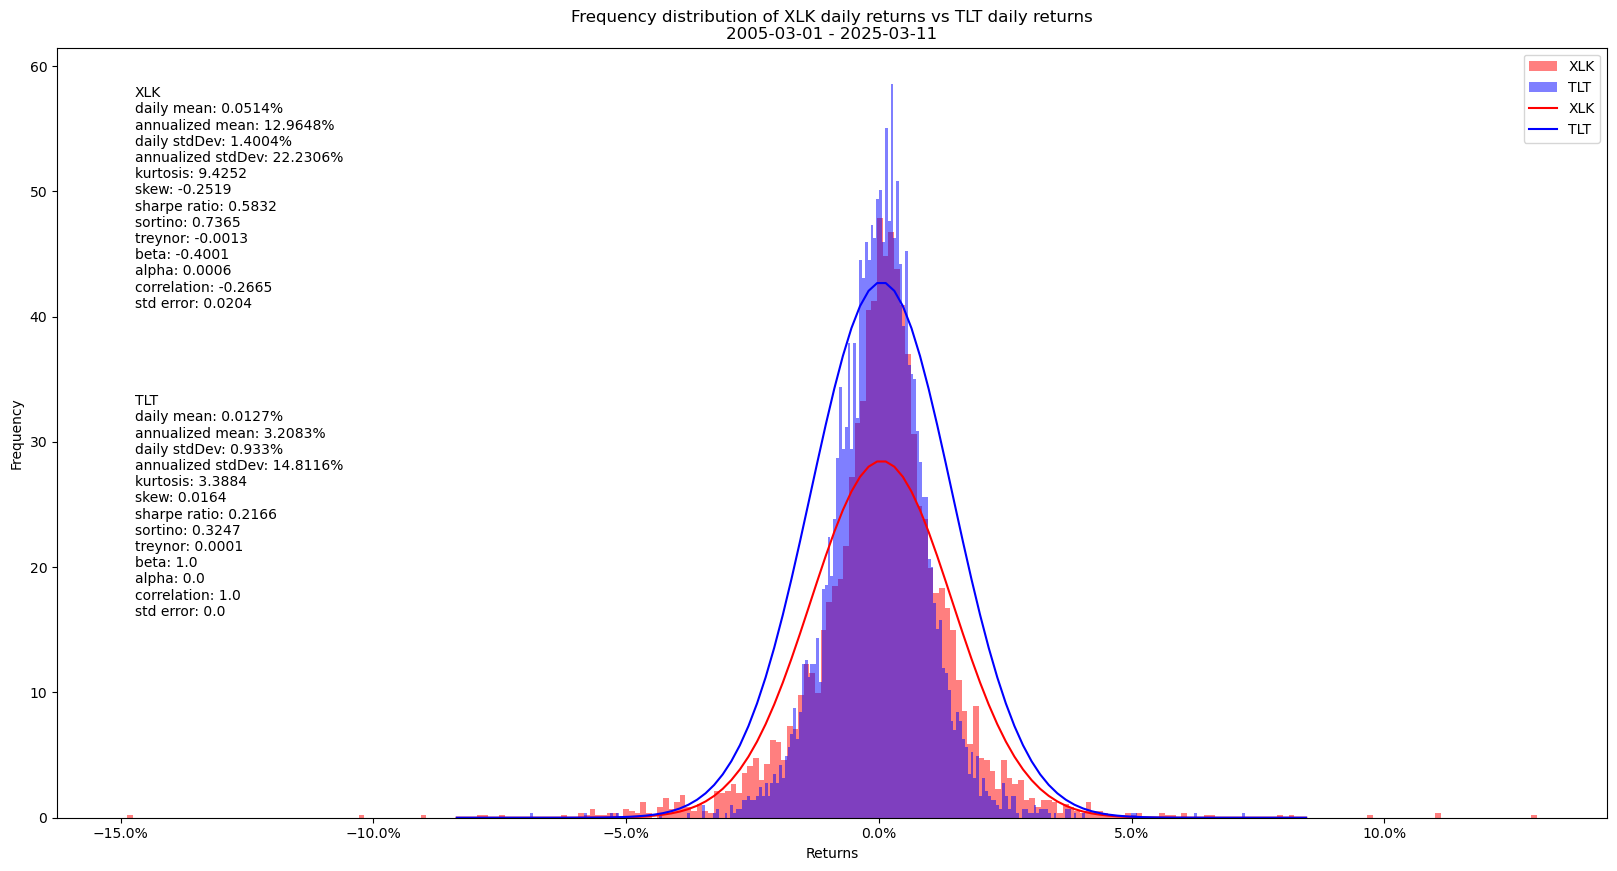

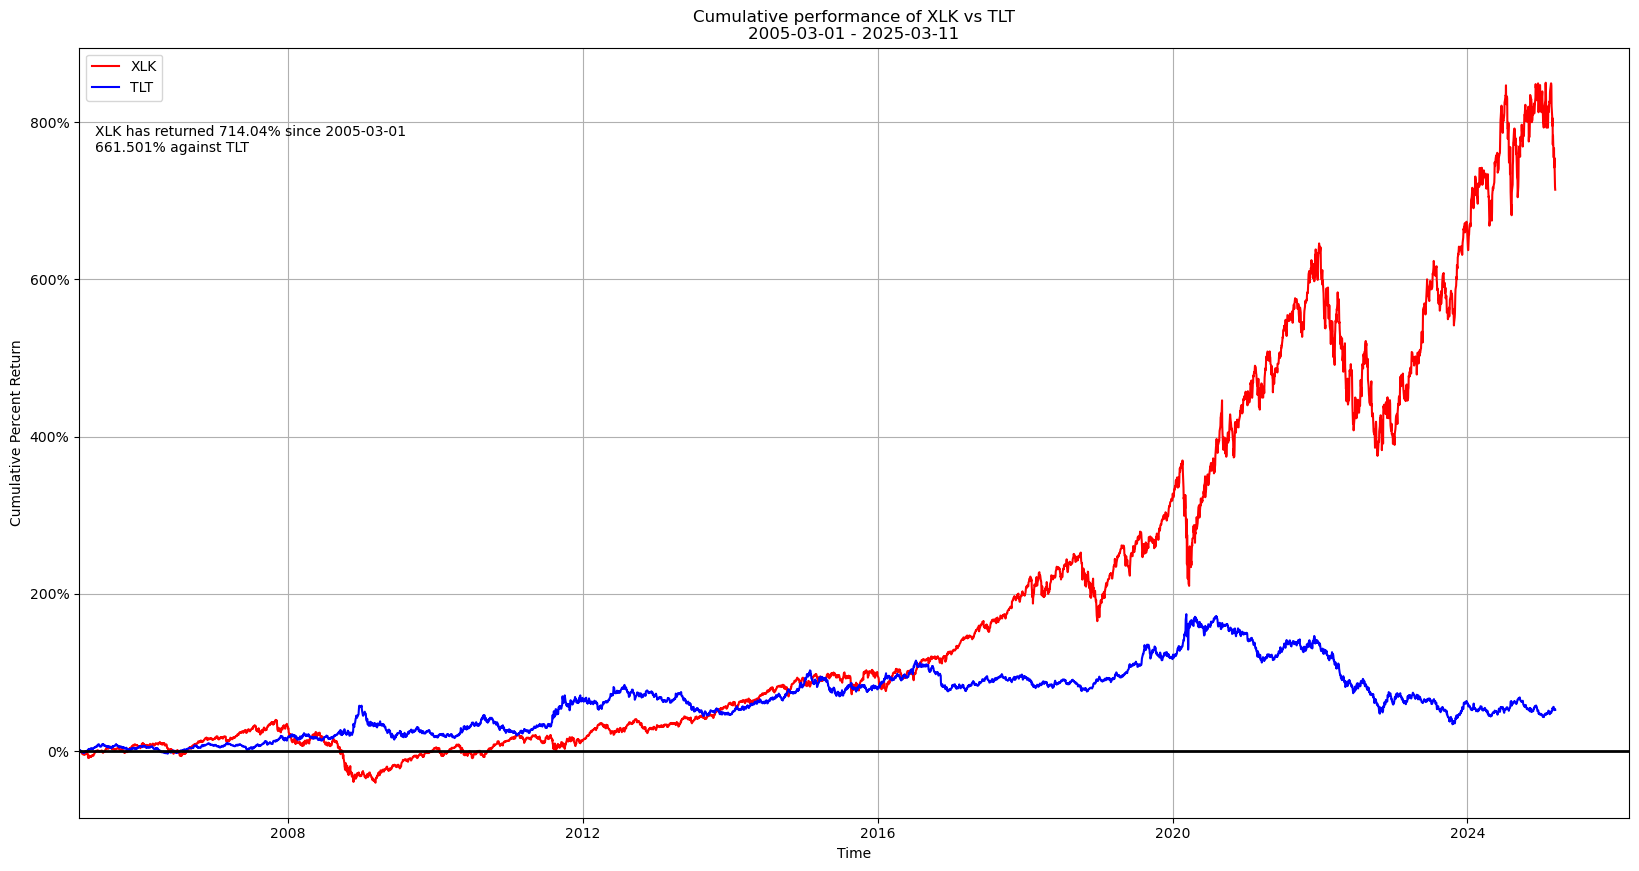

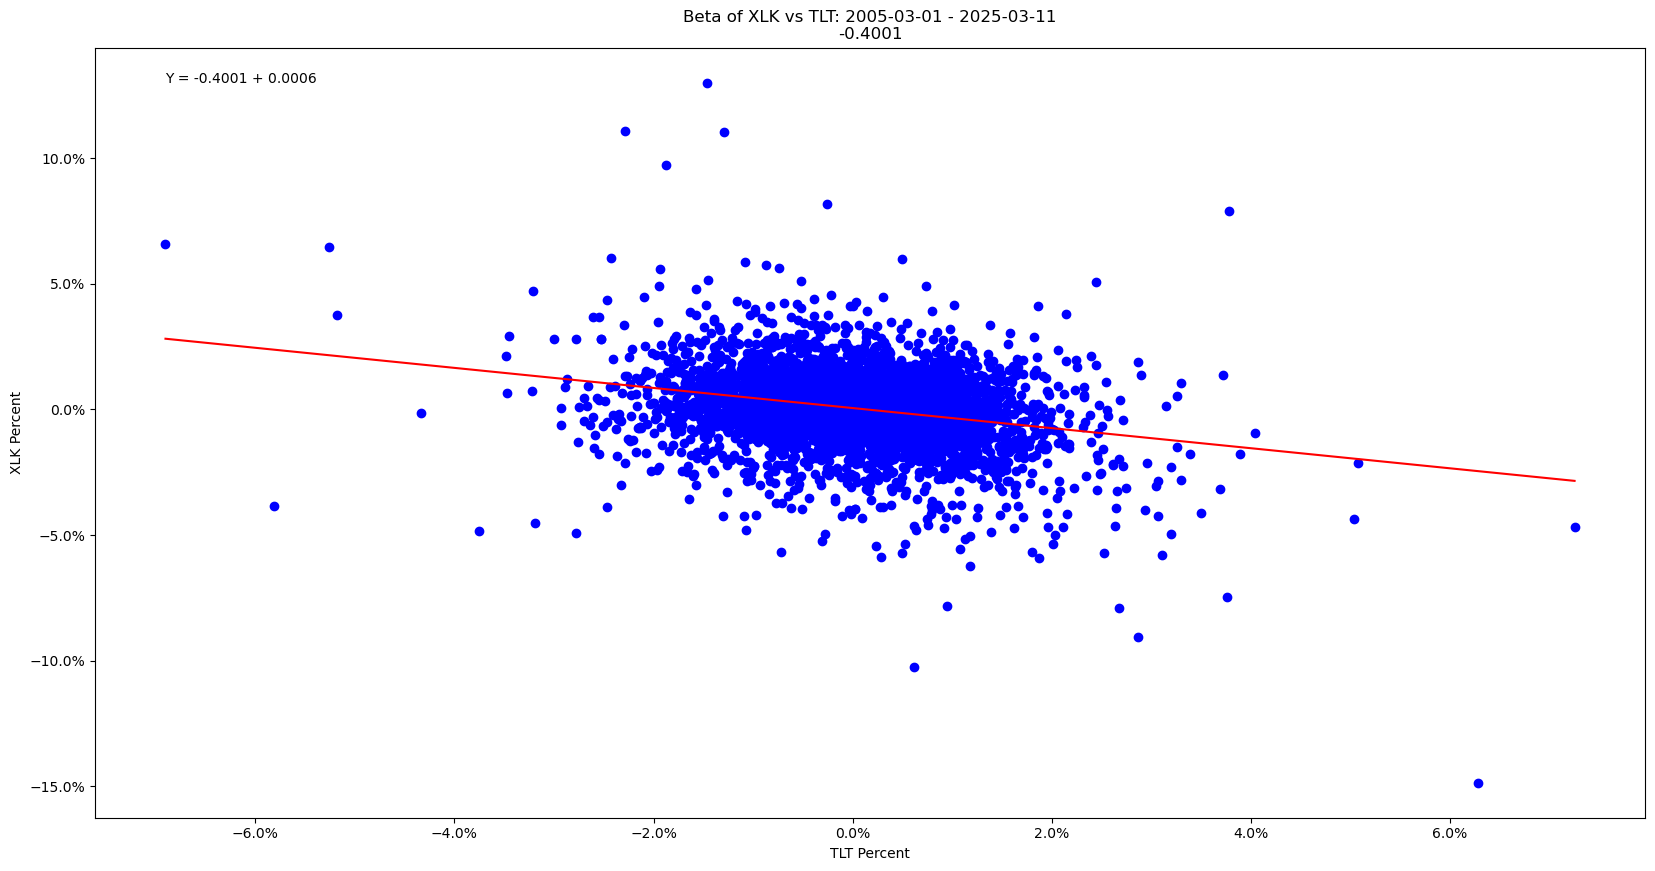

In [17]:
# draw graphs
graphHistDescribe(ticker_rets, bench_rets)
graphCumRets(ticker_rets, bench_rets)
graphBeta(ticker_rets, bench_rets)

In [12]:
describeRets(ticker_rets, bench_rets)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

In [20]:
vix= getData(['^vix'], startdate, enddate)

[*********************100%***********************]  1 of 1 completed


In [13]:
ticker = 'XLV'
# def scrapePrice(ticker):
    # Uses requests and BS4 to scrape the current price of the str ticker input from Yahoo Finance
    # Returns float of current ticker price
import requests
from bs4 import BeautifulSoup as bs4
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
url = "https://finance.yahoo.com/quote/"+ticker+"/history?p="+ticker
site = requests.get(url, headers=headers).text
soup = bs4(site)
#     return float((soup.select('table td')[4].text).replace(',',''))
# scrapePrice('XLV')

In [16]:
raw_data.to_csv('health.csv')

In [18]:
bench_rets

Date
2005-02-07    0.000000
2005-02-08    0.002342
2005-02-09   -0.010753
2005-02-10    0.001687
2005-02-11    0.010068
                ...   
2025-02-11   -0.001847
2025-02-12   -0.001439
2025-02-13    0.003901
2025-02-14   -0.010921
2025-02-18   -0.001936
Name: XLV, Length: 5040, dtype: float64

Expected Return (Ticker, Adjusted): 10.9355%
Expected Return (Benchmark, Adjusted): 9.8971%


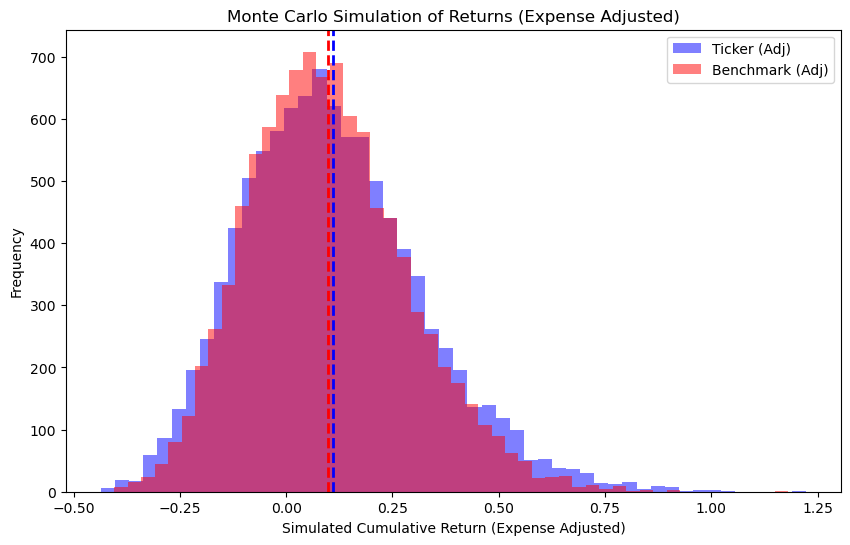

In [34]:
# Set parameters
n_sims = 10000  # Number of Monte Carlo simulations
n_days = 252  # Simulated period (e.g., one trading year)

# Function to run Monte Carlo simulation
def monte_carlo_simulation(returns, n_sims, n_days):
    sim_results = np.zeros(n_sims)
    
    for i in range(n_sims):
        sampled_returns = np.random.choice(returns, size=n_days, replace=True)
        sim_results[i] = np.prod(1 + sampled_returns) - 1  # Compute cumulative return

    return sim_results

# Define expense ratios (e.g., 0.005 for 0.5% annual)
ticker_expense_ratio = 0.0065  # Adjust this for your ticker
bench_expense_ratio = 0.0008  # Adjust this for the benchmark

# Convert to daily deduction
trading_days = 252
ticker_daily_expense = ticker_expense_ratio / trading_days
bench_daily_expense = bench_expense_ratio / trading_days

# Adjust returns
ticker_rets_adj = ticker_rets - ticker_daily_expense
bench_rets_adj = bench_rets - bench_daily_expense

# Run Monte Carlo simulation on adjusted returns
ticker_sims = monte_carlo_simulation(ticker_rets_adj, n_sims, n_days)
bench_sims = monte_carlo_simulation(bench_rets_adj, n_sims, n_days)

# Compute expected returns
mean_ticker_return = np.mean(ticker_sims)
mean_bench_return = np.mean(bench_sims)

print(f"Expected Return (Ticker, Adjusted): {mean_ticker_return:.4%}")
print(f"Expected Return (Benchmark, Adjusted): {mean_bench_return:.4%}")

# Plot distributions
plt.figure(figsize=(10,6))
plt.hist(ticker_sims, bins=50, alpha=0.5, label="Ticker (Adj)", color="blue")
plt.hist(bench_sims, bins=50, alpha=0.5, label="Benchmark (Adj)", color="red")
plt.axvline(mean_ticker_return, color="blue", linestyle="dashed", linewidth=2)
plt.axvline(mean_bench_return, color="red", linestyle="dashed", linewidth=2)
plt.legend()
plt.xlabel("Simulated Cumulative Return (Expense Adjusted)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation of Returns (Expense Adjusted)")
plt.show()
plt.show()



In [29]:
ticker_rets.name

'FSPHX'